In [20]:
%matplotlib inline

from __future__ import print_function
import datetime
import numpy as np
import pandas as pd
from matplotlib import cm, pyplot as plt, finance
from matplotlib.dates import YearLocator, MonthLocator
from hmmlearn.hmm import GaussianHMM
import pandas_datareader.data as web

In [33]:
###############################################################################
# Get quotes from Yahoo! finance
###############################################################################
ticker = "GOOGL"
start_date = datetime.date(2000, 1, 1)
#end_date = datetime.date.today()
end_date = datetime.date.today() - datetime.timedelta(days=15)


In [35]:
quotes = web.DataReader("GOOGL", 'yahoo', start_date, end_date)

In [36]:
quotes.reset_index(inplace=True,drop=False)
quotes.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000
1,2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300
2,2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100
3,2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600


In [37]:
quotes.drop(['Open','High','Low','Adj Close'],axis=1,inplace=True)

In [38]:
quotes.head()

,Date,Close,Volume
0,2004-08-19,50.220219,44659000
1,2004-08-20,54.209209,22834300
2,2004-08-23,54.754753,18256100
3,2004-08-24,52.487488,15247300
4,2004-08-25,53.053055,9188600


In [39]:
quotes['Date'] = quotes['Date'].apply(datetime.datetime.toordinal)

In [40]:
quotes = list(quotes.itertuples(index=False, name=None))

In [41]:
quotes

[(731812, 50.220219, 44659000),
 (731813, 54.209208999999994, 22834300),
 (731816, 54.754753, 18256100),
 (731817, 52.487488, 15247300),
 (731818, 53.05305500000001, 9188600),
 (731819, 54.009009999999996, 7094800),
 (731820, 53.128128000000004, 6211700),
 (731823, 51.056057, 5196700),
 (731824, 51.236237, 4917800),
 (731825, 50.175175, 9138200),
 (731826, 50.805805, 15118600),
 (731827, 50.055054, 5152400),
 (731831, 50.840839, 5847500),
 (731832, 51.201202, 4985600),
 (731833, 51.206207, 4061700),
 (731834, 52.717716, 8698800),
 (731837, 53.803802000000005, 7844100),
 (731838, 55.8008, 10828900),
 (731839, 56.056056999999996, 10713000),
 (731840, 57.042042, 9266300),
 (731841, 58.803802000000005, 9472500),
 (731844, 59.739738, 10628700),
 (731845, 58.978977, 7228700),
 (731846, 59.249249, 7581200),
 (731847, 60.47047, 8535600),
 (731848, 59.974976, 9123400),
 (731851, 59.18919, 7066100),
 (731852, 63.493492, 16929000),
 (731853, 65.60560600000001, 30516400),
 (731854, 64.864868, 1375

In [42]:
# Unpack quotes
dates = np.array([q[0] for q in quotes], dtype=int)
close_v = np.array([q[1] for q in quotes])
volume = np.array([q[2] for q in quotes])[1:]

In [43]:
# Take diff of close value. Note that this makes
# ``len(diff) = len(close_t) - 1``, therefore, other quantities also
# need to be shifted by 1.
diff = np.diff(close_v)
dates = dates[1:]
close_v = close_v[1:]

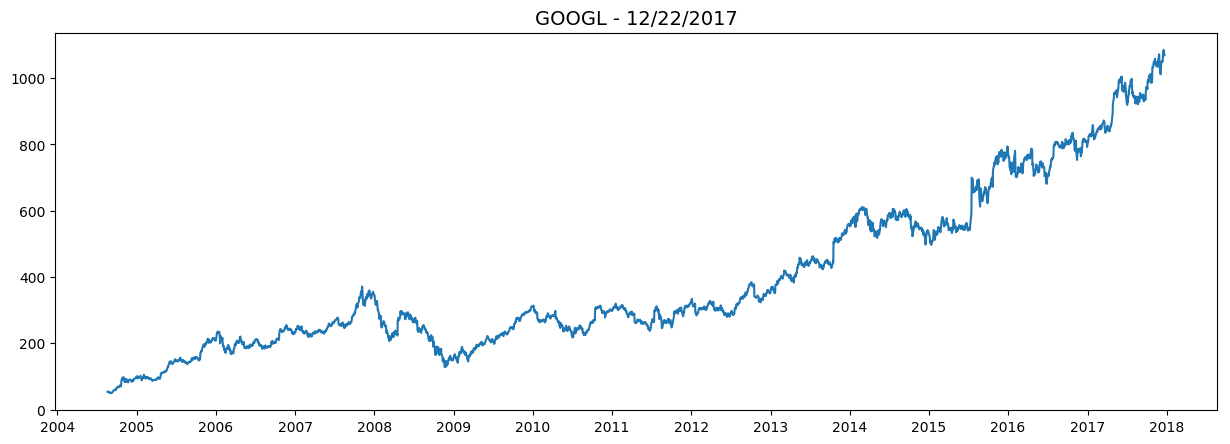

In [44]:
# Pack diff and volume for training.
X = np.column_stack([diff, volume])
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker + " - " + end_date.strftime("%m/%d/%Y"), fontsize = 14)
plt.gca().xaxis.set_major_locator(YearLocator())
plt.plot_date(dates,close_v,"-")
plt.show()

In [45]:
###############################################################################
# Run Gaussian HMM
###############################################################################
print("fitting to HMM and decoding ...", end="")
# Make an HMM instance and execute fit
model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000).fit(X)
# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)
print("done")



fitting to HMM and decoding ...

/home/pavan/anaconda3/envs/ubuntu_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


done


In [46]:
###############################################################################
# Print trained parameters and plot
###############################################################################
print("Transition matrix - probability of going to any particular state")
print(model.transmat_)

print("Means and vars of each hidden state")
params = pd.DataFrame(columns=('State', 'Means', 'Variance'))
for i in range(model.n_components):
    params.loc[i] = [format(i), model.means_[i],np.diag(model.covars_[i])]
params

Transition matrix - probability of going to any particular state
[[  9.77475491e-01   1.28516001e-22   2.03902576e-02   2.13425138e-03]
 [  3.97055210e-31   9.02671141e-01   5.87291622e-02   3.85996967e-02]
 [  6.02580445e-02   1.73772868e-01   7.18362877e-01   4.76062106e-02]
 [  2.70254401e-03   2.95443359e-02   9.09784872e-03   9.58655271e-01]]
Means and vars of each hidden state


,State,Means,Variance
0,0,"[0.511760149764, 1779339.95836]","[58.7487337554, 363781254543.0]"
1,1,"[0.0793521772592, 12534590.6409]","[17.6481434454, 1.63744184684e+13]"
2,2,"[0.0223669929703, 24557326.473]","[203.836706729, 2.17443175771e+14]"
3,3,"[0.384106357579, 4982658.42373]","[13.6246862892, 2.35752202839e+12]"


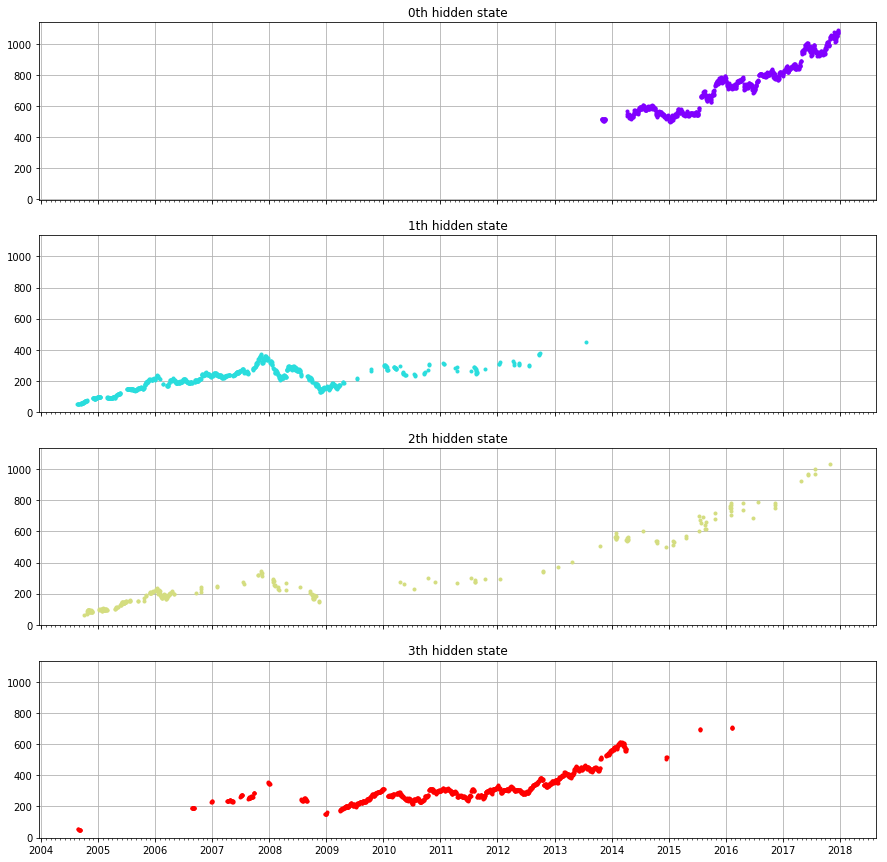

In [47]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(dates[mask], close_v[mask], ".", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)
plt.show()



In [48]:


#dot product Transition Matrix to Means to get the expected return and volumes for a particular state
expected_returns_and_volumes = np.dot(model.transmat_, model.means_)
returns_and_volume_columnwise = list(zip(*expected_returns_and_volumes))
expected_returns = returns_and_volume_columnwise[0]
expected_volumes = returns_and_volume_columnwise[1]
params = pd.concat([pd.Series(expected_returns), pd.Series(expected_volumes)], axis=1)
params.columns= ['Returns', 'Volume']
print (params)



    Returns        Volume
0  0.501509  2.250626e+06
1  0.087769  1.294917e+07
2  0.078980  2.016367e+07
3  0.372157  5.375206e+06


In [49]:


#get quotes for last N days
lastN = 100
start_date = datetime.date.today() - datetime.timedelta(days=lastN*2) #even beyond N days
end_date = datetime.date.today() 

dates = np.array([q[0] for q in quotes], dtype=int)



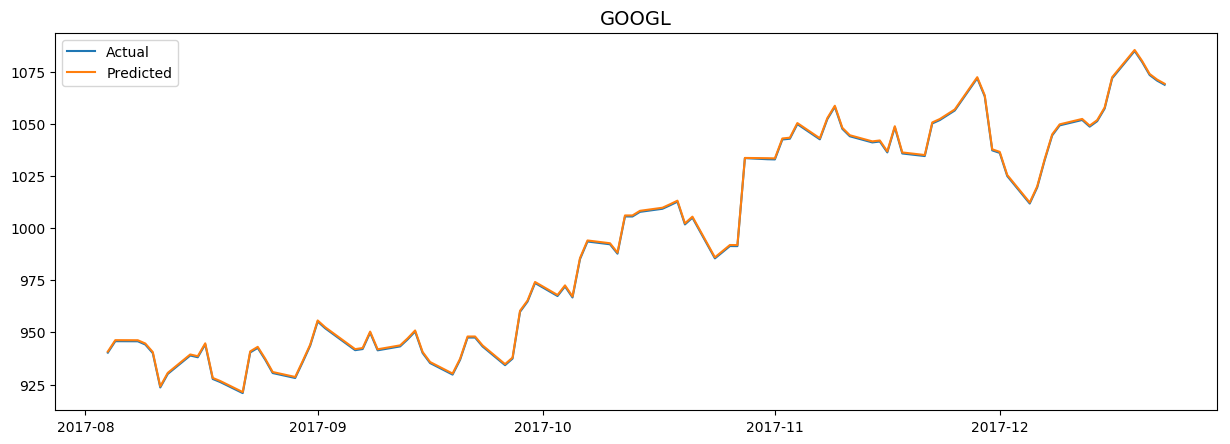

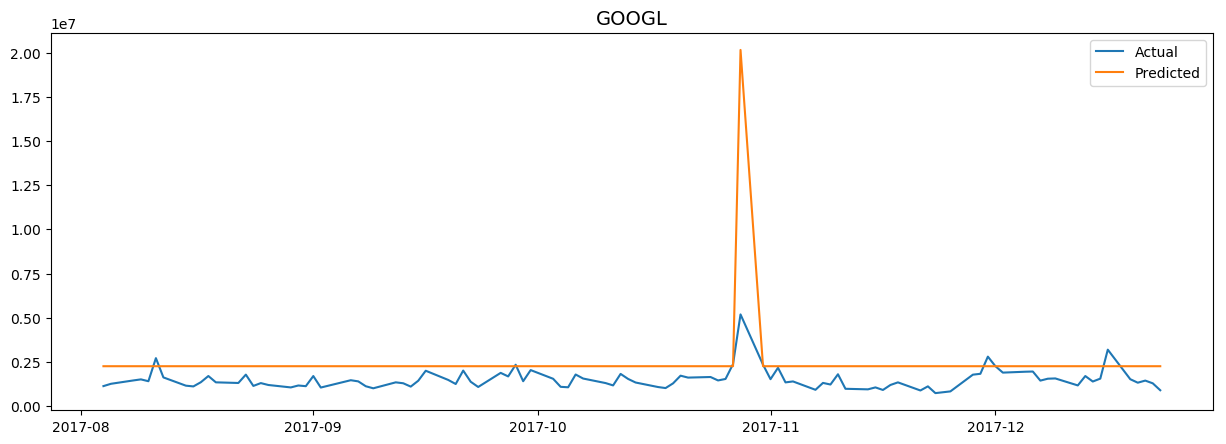

In [50]:
predicted_prices = []
predicted_dates = []
predicted_volumes = []
actual_volumes = []

for idx in range(lastN):
    state = hidden_states[-lastN+idx]
    current_price = quotes[-lastN+idx][1]
    volume = quotes[-lastN+idx][2]
    actual_volumes.append(volume)
    current_date = datetime.date.fromordinal(dates[-lastN+idx])
    predicted_date = current_date + datetime.timedelta(days=1)
    predicted_dates.append(predicted_date)
    predicted_prices.append(current_price + expected_returns[state])
    predicted_volumes.append(np.round(expected_volumes[state]))    

#Returns
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker, fontsize = 14)
plt.plot(predicted_dates,close_v[-lastN:])
plt.plot(predicted_dates,predicted_prices)
plt.legend(['Actual','Predicted'])
plt.show()

#Volumes
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker, fontsize = 14)
plt.plot(predicted_dates,actual_volumes)
plt.plot(predicted_dates,predicted_volumes)
plt.legend(['Actual','Predicted'])
plt.show()

In [51]:
 actual_volumes

[1123900,
 1254600,
 1445800,
 1505100,
 1400900,
 2707400,
 1616700,
 1148500,
 1106500,
 1345300,
 1695700,
 1337400,
 1301200,
 1775100,
 1134500,
 1294600,
 1187300,
 1049400,
 1158600,
 1120300,
 1693300,
 1042900,
 1457400,
 1391500,
 1116600,
 999900,
 1337400,
 1284800,
 1095400,
 1427400,
 1994300,
 1473700,
 1242700,
 2004000,
 1370700,
 1074800,
 1873400,
 1672700,
 2334600,
 1400900,
 2031100,
 1539100,
 1083300,
 1057800,
 1780900,
 1553000,
 1295500,
 1163400,
 1815000,
 1530700,
 1327600,
 1071000,
 1013000,
 1279800,
 1714200,
 1606000,
 1639300,
 1445100,
 1528700,
 2369800,
 5184100,
 2340200,
 1516300,
 2163100,
 1334700,
 1388500,
 914700,
 1305200,
 1213800,
 1794600,
 972100,
 940700,
 1050600,
 905300,
 1188400,
 1335600,
 876300,
 1110300,
 726900,
 824600,
 1771500,
 1821200,
 2793300,
 2254600,
 1888100,
 1938900,
 1949900,
 1435500,
 1543300,
 1558500,
 1162700,
 1694100,
 1384000,
 1548100,
 3188000,
 1514600,
 1317500,
 1436400,
 1282000,
 889400]